In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline


DATASET_PATH = "/teamspace/studios/this_studio/nlp-hr-feedback/training_pipeline/topic_modeling/topic_modeling/datasets/tesla.pkl"

In [2]:
# Replace 'your_file.jsonl' with your actual file path
df = pd.read_pickle(DATASET_PATH).head(500)

# Display the first few rows of the DataFrame
print(df.head())


                                            Topic  \
0  Please Read First Before Posting On The Forums   
1  Please Read First Before Posting On The Forums   
2  Please Read First Before Posting On The Forums   
3  Please Read First Before Posting On The Forums   
4  Please Read First Before Posting On The Forums   

                                          Discussion                  User  \
0  Tesla’s forum provides an online meeting space...       Tesla Ownership   
1  I order Tesla 3 last night and still have not ...      Ts1diva_98033909   
2  I was in the same situation. I emailed and got...  heyitsclint_98036105   
3                                             Ignore               Bighorn   
4  Whups, posting allowed! :-). And flagging, app...                 NKYTA   

                   Time  
0  2016-03-13T18:17:38Z  
1  2016-04-01T17:01:04Z  
2  2016-04-02T05:41:23Z  
3  2016-04-02T16:14:34Z  
4  2016-04-02T20:47:25Z  


In [3]:
documents = df['Discussion'].to_list()

In [4]:
stoplist = ['the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'fish', 'troll', 'ha', 'bye', 'ok', 'okay', 'andy', 'idiot']

# remove common words and tokenize
texts = [[word for word in document.split() if word not in stoplist]
         for document in documents]

In [5]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [6]:
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

In [7]:
# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Filter out words that occur less than X documents, 
# or more than X% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.1)

# Create the corpus.  This is a Term Frequency 
# or Bag of Words representation.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 278
Number of documents: 500


In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [9]:
NUM_TOPICS = 10
chunksize = 2000
passes = 6
iterations = 100
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)

2024-09-12 19:02:34,601 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2024-09-12 19:02:34,602 : INFO : using serial LDA version on this node
2024-09-12 19:02:34,603 : INFO : running online (multi-pass) LDA training, 10 topics, 6 passes over the supplied corpus of 500 documents, updating model once every 500 documents, evaluating perplexity every 500 documents, iterating 100x with a convergence threshold of 0.001000
2024-09-12 19:02:34,605 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-09-12 19:02:34,606 : DEBUG : bound: at document #0
2024-09-12 19:02:34,719 : INFO : -6.915 per-word bound, 120.7 perplexity estimate based on a held-out corpus of 500 documents with 6283 words
2024-09-12 19:02:34,719 : INFO : PROGRESS: pass 0, at document #500/500
2024-09-12 19:02:34,720 : DEBUG : performing inference on a chunk of 500 documents
2024-09-12 19:02:34,

In [10]:
def compute_coherence_values(dictionary, corpus, texts, 
                             cohere, limit, start=2, step=2):

    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         random_state=42,)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [11]:
limit=50
start=2
step=2

coherence_values = compute_coherence_values(dictionary=dictionary, 
                                            corpus=corpus, 
                                            texts=texts, 
                                            cohere='c_v', 
                                            start=start, 
                                            limit=limit, 
                                            step=step)

2024-09-12 19:02:41,004 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2024-09-12 19:02:41,006 : INFO : using serial LDA version on this node
2024-09-12 19:02:41,006 : INFO : running online (multi-pass) LDA training, 2 topics, 6 passes over the supplied corpus of 500 documents, updating model once every 500 documents, evaluating perplexity every 500 documents, iterating 100x with a convergence threshold of 0.001000
2024-09-12 19:02:41,007 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-09-12 19:02:41,008 : DEBUG : bound: at document #0
2024-09-12 19:02:41,236 : INFO : -6.115 per-word bound, 69.3 perplexity estimate based on a held-out corpus of 500 documents with 6283 words
2024-09-12 19:02:41,237 : INFO : PROGRESS: pass 0, at document #500/500
2024-09-12 19:02:41,237 : DEBUG : performing inference on a chunk of 500 documents
2024-09-12 19:02:41,445 : DEBUG : 281/500 documents converged 

2024-09-12 19:03:19,415 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-09-12 19:03:19,416 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-09-12 19:03:19,417 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-09-12 19:03:19,417 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='nor

2024-09-12 19:03:19,557 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-09-12 19:03:19,559 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-09-12 19:03:19,560 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-09-12 19:03:19,561 : DEBUG : findfont: score(FontEntry(fname='/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='nor

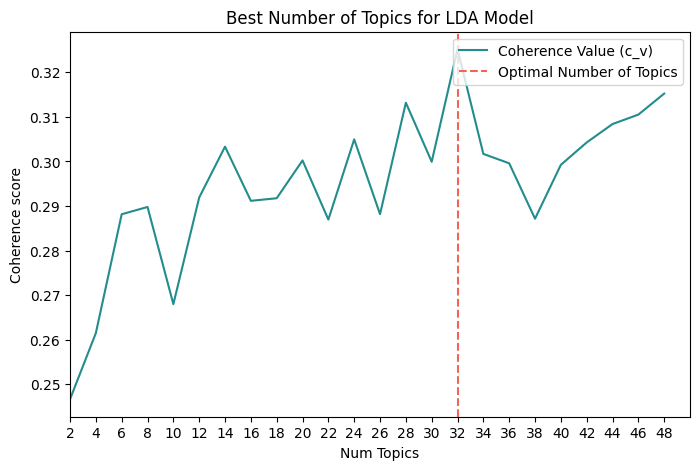

In [12]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

In [13]:
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=100,
    num_topics=8,
    passes=8,
    eval_every=None)

2024-09-12 19:04:12,712 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2024-09-12 19:04:12,713 : INFO : using serial LDA version on this node
2024-09-12 19:04:12,714 : INFO : running online (multi-pass) LDA training, 8 topics, 8 passes over the supplied corpus of 500 documents, updating model once every 500 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2024-09-12 19:04:12,715 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-09-12 19:04:12,715 : INFO : PROGRESS: pass 0, at document #500/500
2024-09-12 19:04:12,716 : DEBUG : performing inference on a chunk of 500 documents
2024-09-12 19:04:12,830 : DEBUG : 467/500 documents converged within 100 iterations
2024-09-12 19:04:12,831 : INFO : optimized alpha [0.09712144, 0.097349465, 0.09817113, 0.10855281, 0.099580936, 0.097998194, 0.1037

In [14]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

2024-09-12 19:04:22,103 : DEBUG : performing inference on a chunk of 500 documents
2024-09-12 19:04:22,147 : DEBUG : 500/500 documents converged within 100 iterations
